# Extreme value and survival analysis 

Outline:  
1. Basic Straregy Simulation
    * Objective: Optimising trading profit
    * Method: Momentum Strategy

2. Risk Measures - on strategy
    * Volatility: GARCH Volatility Model    
    * Risk Metrics: VaR, ES (95% confidence level)

3. Extreme Value Theory
    * Extreme Value Theory: Block Maxima
    * Application to Market Risk - Compare with VaR Breaches

3. Survival Analysis: 
    * The need for distributional assumption? we'll check 
    * Application to Market Risk - VaR Breach

3. Hedging with Survival Analysis
    * Hedging Method: all in all out
    * Performance Evaluation and parameter optimisation:  Risk-Adjusted Return (aka sharpe ratio)
    
4. Risk Budgeting - Strategy simulation and Survival Analysis (integrate everything and make it more realistic) 
    **Model Design & Flow:**
    * Generative Approach
    * Strategy Simulation  
    * Survival Analysis of Trades  
    * Risk Budgeting (Kelly's criterion, VaR and Survival Probability of trade)  
    * criteria of trade: positive expected return   
        ${Pr(Survival)_t * E(Profit)} - {Pr(Hazard) * E(EV Loss)} $

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go

import yfinance as yf 
import datetime as dt

import backtesting as bt

/Users/yuhuiwang/opt/anaconda3/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## 1. Basic Straregy Simulation


In [2]:
# define sma startegy
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

In [3]:
from backtesting import Strategy
from backtesting.lib import crossover


class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10
    n2 = 20
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In [4]:
%%script echo

    def next(self):
        if (self.sma1[-2] < self.sma2[-2] and
                self.sma1[-1] > self.sma2[-1]):
            self.position.close()
            self.buy()

        elif (self.sma1[-2] > self.sma2[-2] and    # Ugh!
              self.sma1[-1] < self.sma2[-1]):
            self.position.close()
            self.sell()

In [5]:
from backtesting import Backtest

MMM = yf.download('MMM', start='2000-01-01', end=dt.datetime.today())


bt = Backtest(MMM, SmaCross, cash=10_000, commission=.002)
stats = bt.run()
stats

[*********************100%***********************]  1 of 1 completed


Start                     2000-01-03 00:00:00
End                       2023-03-07 00:00:00
Duration                   8464 days 00:00:00
Exposure Time [%]                   99.314011
Equity Final [$]                  3046.797337
Equity Peak [$]                  14355.956814
Return [%]                         -69.532027
Buy & Hold Return [%]              126.945688
Return (Ann.) [%]                   -5.006668
Volatility (Ann.) [%]               21.644913
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -84.893827
Avg. Drawdown [%]                  -11.077028
Max. Drawdown Duration     5262 days 00:00:00
Avg. Drawdown Duration      467 days 00:00:00
# Trades                                  308
Win Rate [%]                        35.064935
Best Trade [%]                      20.339626
Worst Trade [%]                    -15.416017
Avg. Trade [%]                    

In [6]:
bt.plot()

Row(id='1450', ...)

In [7]:
%%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

/Users/yuhuiwang/opt/anaconda3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 3 s, sys: 33.4 ms, total: 3.03 s
Wall time: 3.03 s


Start                     2000-01-03 00:00:00
End                       2023-03-07 00:00:00
Duration                   8464 days 00:00:00
Exposure Time [%]                    98.79952
Equity Final [$]                 15190.582283
Equity Peak [$]                   20666.71569
Return [%]                          51.905823
Buy & Hold Return [%]              126.945688
Return (Ann.) [%]                    1.823297
Volatility (Ann.) [%]               22.404684
Sharpe Ratio                          0.08138
Sortino Ratio                          0.1189
Calmar Ratio                         0.030099
Max. Drawdown [%]                  -60.577488
Avg. Drawdown [%]                   -9.339543
Max. Drawdown Duration     3178 days 00:00:00
Avg. Drawdown Duration      253 days 00:00:00
# Trades                                  104
Win Rate [%]                        39.423077
Best Trade [%]                      52.064193
Worst Trade [%]                    -17.285429
Avg. Trade [%]                    

In [8]:
stats._strategy

<Strategy SmaCross(n1=20,n2=60)>

In [9]:
bt.plot(plot_volume=False, plot_pl=False)

Row(id='2059', ...)

## Risk Measures

In [10]:
# get the returns of the strategy
strat = pd.DataFrame(stats._strategy.data.Close)
strat = strat.rename(columns={'Close': 'Close'})
strat['Returns'] = strat['Close'].pct_change()

# get the dates 
strat['Date'] = MMM.index
strat.set_index('Date', inplace=True)
strat = strat.dropna()
strat.head()

Close   Returns
Date                         
2000-01-04  45.3125 -0.039735
2000-01-05  46.6250  0.028966
2000-01-06  50.3750  0.080429
2000-01-07  51.3750  0.019851
2000-01-10  51.1250 -0.004866

In [11]:
import arch

# model the risk of the strategy
model = arch.arch_model(strat['Returns']*100, mean='constant', dist = 't',vol='GARCH', p=1, q=1)
model_fit = model.fit()
model_fit.summary()

# get conditional volatility
cond_vol = model_fit.conditional_volatility/100
cond_vol = pd.DataFrame(cond_vol)
cond_vol = cond_vol.rename(columns={'conditional_volatility': 'Volatility'})
cond_vol.head()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 190444.98530698224
Iteration:      2,   Func. Count:     17,   Neg. LLF: 86177.60016304889
Iteration:      3,   Func. Count:     25,   Neg. LLF: 35581.658953848644
Iteration:      4,   Func. Count:     33,   Neg. LLF: 14388.06091816064
Iteration:      5,   Func. Count:     40,   Neg. LLF: 17000.825703852548
Iteration:      6,   Func. Count:     47,   Neg. LLF: 9624.233166392434
Iteration:      7,   Func. Count:     53,   Neg. LLF: 14441.299961695862
Iteration:      8,   Func. Count:     60,   Neg. LLF: 10449.49020634056
Iteration:      9,   Func. Count:     70,   Neg. LLF: 9621.16478969814
Iteration:     10,   Func. Count:     76,   Neg. LLF: 9621.232149205462
Iteration:     11,   Func. Count:     83,   Neg. LLF: 9621.07599294611
Iteration:     12,   Func. Count:     89,   Neg. LLF: 9621.073185761705
Iteration:     13,   Func. Count:     95,   Neg. LLF: 9621.072338573653
Iteration:     14,   Func. Count:    101,   Neg. LLF: 9621.072

cond_vol
Date                
2000-01-04  0.030711
2000-01-05  0.031277
2000-01-06  0.031095
2000-01-07  0.035466
2000-01-10  0.034740

<AxesSubplot:xlabel='Date'>

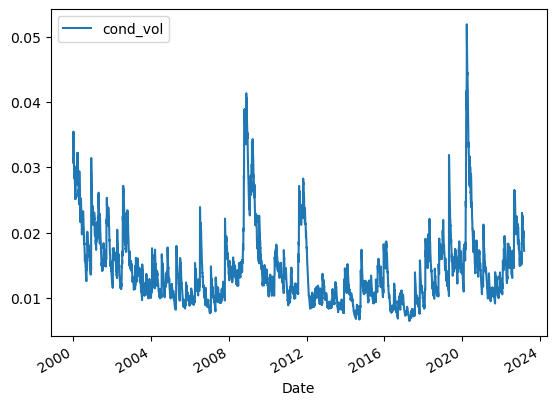

In [12]:
cond_vol.plot()

In [13]:
from pyextremes import EVA

model = EVA(strat.Returns)

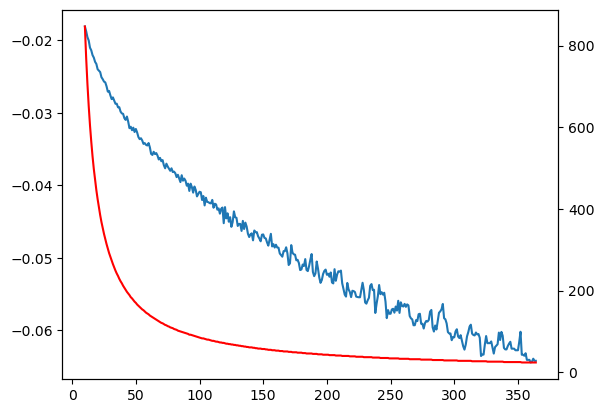

In [14]:
mean = []
count = []
for x in range(10, 365):
    # select optimal block size by lowest mean value
    model.get_extremes(method="BM", extremes_type='low', block_size=f'{x}D')
    mean.append(model.extremes.mean())
    count.append(model.extremes.count())

# plot the mean values
plt.plot(np.arange(10,365,1), mean)
# plot the count values on second axis
plt.twinx()
plt.plot(np.arange(10,365,1), count, color='red')

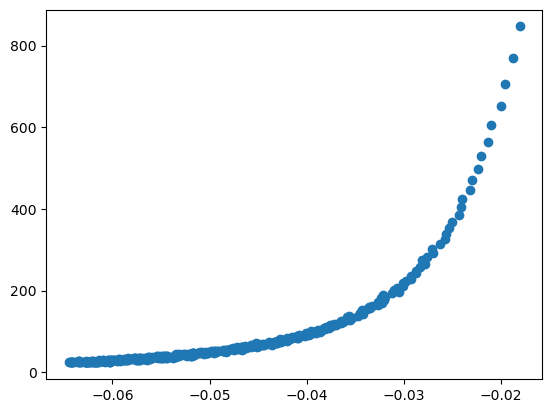

In [15]:
# plot scatter of count and mean
plt.scatter(mean, count)


(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Date', ylabel='Returns'>)

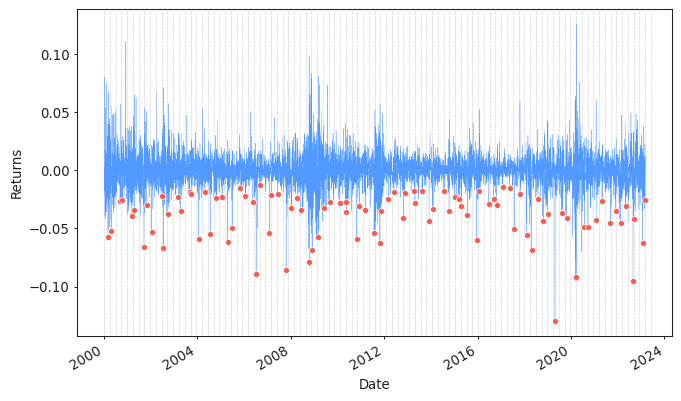

In [16]:
model.get_extremes(method="BM", extremes_type='low', block_size="90D")
model.plot_extremes()

In [17]:
model.fit_model()
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)


(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='Returns'>,
  <AxesSubplot:title={'center':'Probability density plot'}, xlabel='Returns', ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

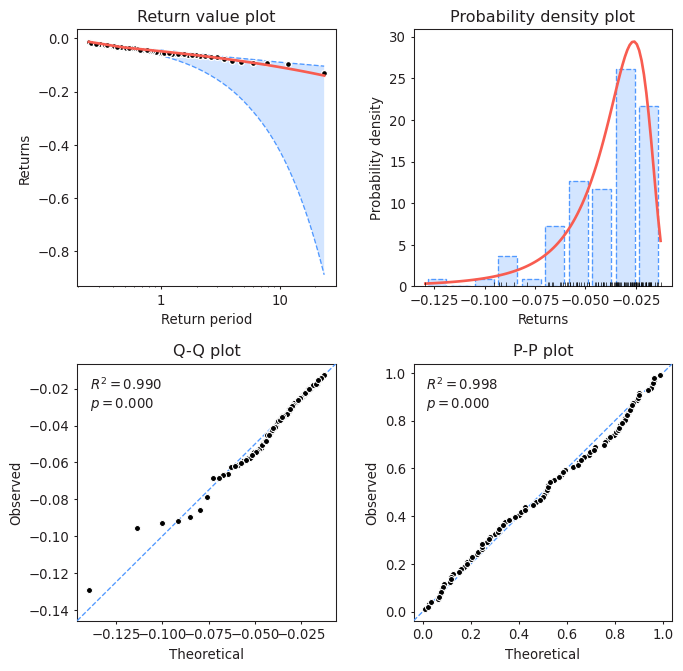

In [18]:
model.plot_diagnostic(alpha=0.95)


### Comparing with VaR from Garch Model

In [19]:
# im using 1.644 here assuming 95% confidence level and normal distribution (cant get my scipy to work somehow)
garch_var = cond_vol * 1.644

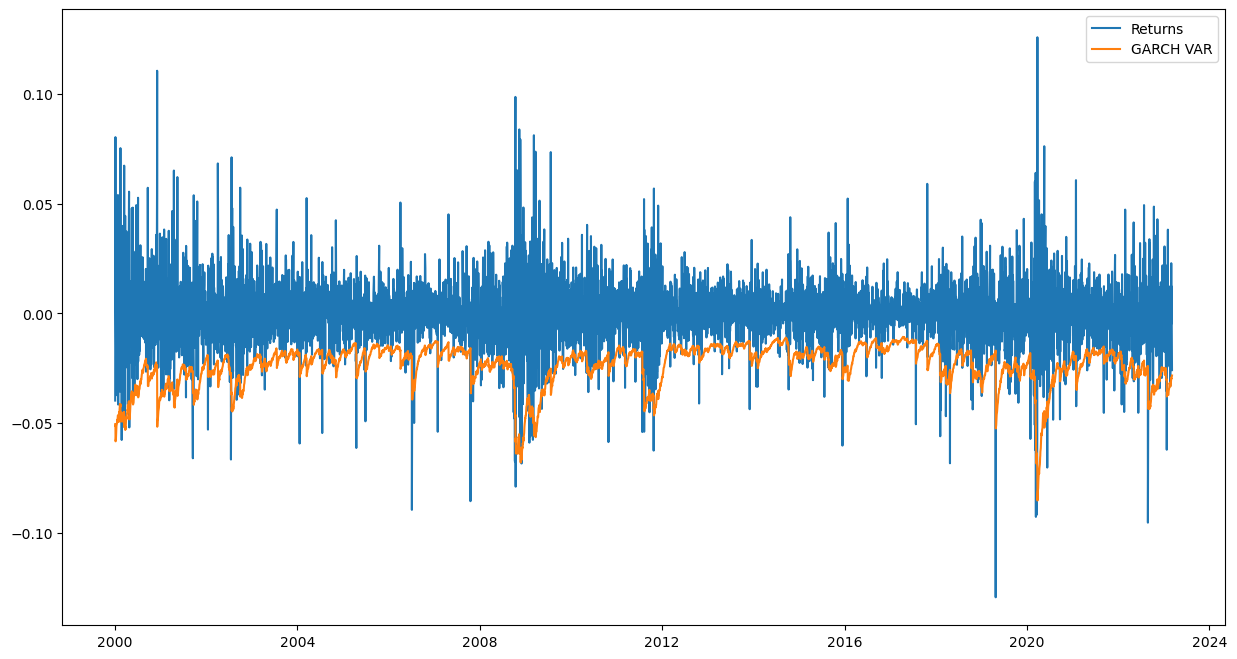

In [20]:
# plot return and var 
plt.figure(figsize=(15, 8))
plt.plot(strat['Returns'], label='Returns')
plt.plot(-garch_var, label='GARCH VAR')
plt.legend()
plt.show()



In [21]:
# join df 
strat = pd.concat([strat, cond_vol, garch_var], axis=1)
strat = strat.dropna()
strat.columns = ['Close', 'Returns', 'Volatility', 'GARCH_VAR']
strat.head()


Close   Returns  Volatility  GARCH_VAR
Date                                                
2000-01-04  45.3125 -0.039735    0.030711   0.050490
2000-01-05  46.6250  0.028966    0.031277   0.051419
2000-01-06  50.3750  0.080429    0.031095   0.051120
2000-01-07  51.3750  0.019851    0.035466   0.058307
2000-01-10  51.1250 -0.004866    0.034740   0.057112

In [22]:
breaches = strat[strat['Returns'] < -strat['GARCH_VAR']]
breaches

Close   Returns  Volatility  GARCH_VAR
Date                                                   
2000-02-25   42.875000 -0.057692    0.027486   0.045187
2000-03-07   41.375000 -0.051576    0.028202   0.046364
2000-04-26   44.468750 -0.051965    0.027518   0.045239
2000-09-07   45.812500 -0.026560    0.013089   0.021518
2000-09-20   40.875000 -0.025335    0.014757   0.024260
...                ...       ...         ...        ...
2022-12-15  122.379997 -0.029423    0.014888   0.024475
2023-01-18  122.750000 -0.030411    0.015704   0.025818
2023-01-19  118.430000 -0.035193    0.016907   0.027794
2023-01-24  115.000000 -0.062143    0.018304   0.030091
2023-02-21  109.250000 -0.033100    0.019207   0.031577

[227 rows x 4 columns]

In [23]:
# compare the extent 
print('Average breach: ', breaches.Returns.describe())
print('Average extreme return: ', model.extremes.describe())


Average breach:  count    227.000000
mean      -0.034636
std        0.017600
min       -0.129450
25%       -0.043363
50%       -0.030186
75%       -0.022003
max       -0.013066
Name: Returns, dtype: float64
Average extreme return:  count    95.000000
mean     -0.040062
std       0.021624
min      -0.129450
25%      -0.052467
50%      -0.034335
75%      -0.024470
max      -0.012727
Name: Returns, dtype: float64


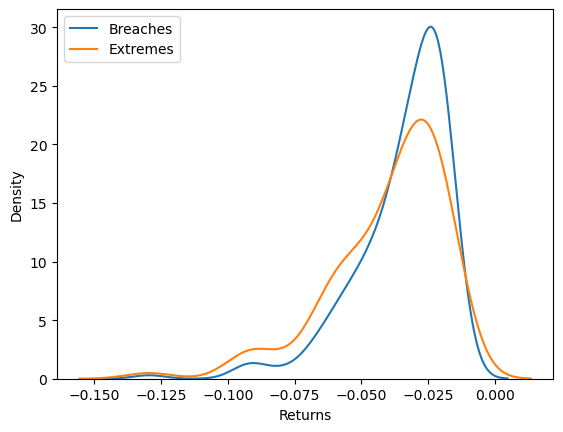

In [24]:
# plot probabailities 
sns.kdeplot(breaches.Returns)
sns.kdeplot(model.extremes)
plt.legend(['Breaches', 'Extremes'])

## Price behaviour prior to event (20 days)

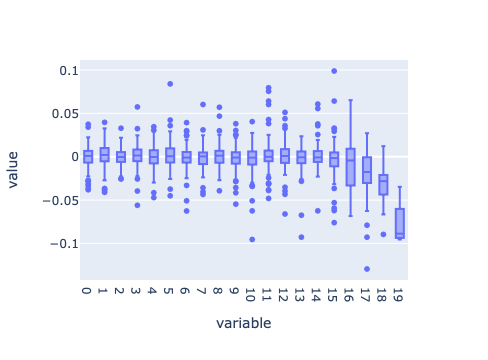

In [25]:
# plot the cumulative returns graph before each extreme using plotly
from datetime import timedelta  
  

# create a list of dates
dates = model.extremes.index.tolist()

# plot using plotly
fig = go.Figure()

k = []
for i in dates:
    a = strat.loc[i-timedelta(days=25):i]['Returns'].apply(lambda x: np.prod(x+1) - 1)
    a = a.reset_index(drop=True)
    k.append(a)
    #fig.add_trace(go.Scatter(x=np.arange(-10,0,1), y=strat.loc[i-timedelta(days=10):i]['Returns'].expanding().sum(), name = str(i)))

# change to scatter 
k_df = pd.DataFrame(k)
k_df.fillna(0)
k_df.reset_index(inplace=True, drop=True)
px.box(k_df)

#px.scatter(k_df, trendline='lowess') 

#fig.update_layout(title='Cumulative Returns', xaxis_title='Date', yaxis_title='Returns')
#fig.show()



## Survival Analysis
Assumptions:
* Hedging objective: to minimise the number of breaches and the extend of losses

In [26]:
# using breach as the event
# df containing return, garch, var, var breach, extreme, (breach and extreme in bool )

df = strat
df['var_breach'] = df['Returns'] < -df['GARCH_VAR']
df['EVA'] = model.extremes
# convert eva to bool, NAN = False, value = True
df['EVA'] = df['EVA'].notnull()
df

Close   Returns  Volatility  GARCH_VAR  var_breach    EVA
Date                                                                      
2000-01-04   45.312500 -0.039735    0.030711   0.050490       False  False
2000-01-05   46.625000  0.028966    0.031277   0.051419       False  False
2000-01-06   50.375000  0.080429    0.031095   0.051120       False  False
2000-01-07   51.375000  0.019851    0.035466   0.058307       False  False
2000-01-10   51.125000 -0.004866    0.034740   0.057112       False  False
...                ...       ...         ...        ...         ...    ...
2023-03-01  110.209999  0.022926    0.017883   0.029400       False  False
2023-03-02  109.900002 -0.002813    0.018162   0.029858       False  False
2023-03-03  111.260002  0.012375    0.017688   0.029079       False  False
2023-03-06  109.930000 -0.011954    0.017429   0.028654       False  False
2023-03-07  107.089996 -0.025835    0.017210   0.028294       False   True

[5830 rows x 6 columns]

In [27]:
# count the number of days to breach / occurance, clock resets after every breach
# create a week column 
strat['binary'] = np.where(strat['EVA'] == True, 1, 0)

# column indicating the days since the last positive delta in var 

# initialise list 
d_sicne_increase = []

# for loop to iterate through each row 
d = 0
for i ,row in enumerate(strat.binary):
    try:
        if row == 0 and strat.binary[i-1] == 0:
            d += 1
            d_sicne_increase.append(d)
    
        # counting only resets after the first positive delta (first positive delta is included in the count)
        elif row == 1 and strat.binary[i-1] == 0:
            d += 1
            d_sicne_increase.append(d)
            d = 0

        # counting only resets after the first positive delta (first positive delta is included in the count)
        elif row == 1 and strat.binary[i-1] == 1:
            d = 0
            d_sicne_increase.append(d)

        # counting only resets after the first positive delta (first positive delta is included in the count)
        elif row == 0 and strat.binary[i-1] == 1:
            d = 0
            d_sicne_increase.append(d)

        # if the row is not a positive delta, the count is not incremented
        else:
            d = 0
            d_sicne_increase.append(d)

    except:
        d = 0
        d_sicne_increase.append(d)




In [28]:
# append d_sicne_increase to delta_var_binary
strat['days_since_last_extreme'] = d_sicne_increase
strat.head(50)

Close   Returns  Volatility  GARCH_VAR  var_breach    EVA  \
Date                                                                       
2000-01-04  45.31250 -0.039735    0.030711   0.050490       False  False   
2000-01-05  46.62500  0.028966    0.031277   0.051419       False  False   
2000-01-06  50.37500  0.080429    0.031095   0.051120       False  False   
2000-01-07  51.37500  0.019851    0.035466   0.058307       False  False   
2000-01-10  51.12500 -0.004866    0.034740   0.057112       False  False   
2000-01-11  50.25000 -0.017115    0.033768   0.055514       False  False   
2000-01-12  50.37500  0.002488    0.033059   0.054349       False  False   
2000-01-13  50.37500  0.000000    0.032116   0.052799       False  False   
2000-01-14  49.65625 -0.014268    0.031200   0.051292       False  False   
2000-01-18  48.56250 -0.022026    0.030506   0.050152       False  False   
2000-01-19  49.40625  0.017375    0.030101   0.049485       False  False   
2000-01-20  47.56250 -0.037318    0.029504   0.048505       False  False   
2000-01-21  47.46875 -0.001971    0.029991   0.049306       False  False   
2000-01-24  46.37500 -0.023041    0.029144   0.047913       False  False   
2000-01-25  45.68750 -0.014825    0.028845   0.047421       False  False   
2000-01-26  48.15625  0.054036    0.028254   0.046450       False  False   
2000-01-27  48.12500 -0.000649    0.030141   0.049551       False  False   
2000-01-28  46.12500 -0.041558    0.029284   0.048143       False  False   
2000-01-31  46.81250  0.014905    0.030095   0.049475       False  False   
2000-02-01  47.06250  0.005340    0.029428   0.048379       False  False   
2000-02-02  46.25000 -0.017264    0.028613   0.047039       False  False   
2000-02-03  45.84375 -0.008784    0.028109   0.046212       False  False   
2000-02-04  44.53125 -0.028630    0.027399   0.045045       False  False   
2000-02-07  43.81250 -0.016140    0.027478   0.045174       False  False   
2000-02-08  43.84375  0.000713    0.026983   0.044360       False  False   
2000-02-09  43.81250 -0.000713    0.026220   0.043106       False  False   
2000-02-10  43.00000 -0.018545    0.025483   0.041893       False  False   
2000-02-11  41.46875 -0.035610    0.025162   0.041367       False  False   
2000-02-14  41.43750 -0.000754    0.025864   0.042521       False  False   
2000-02-15  44.56250  0.075415    0.025138   0.041326       False  False   
2000-02-16  44.15625 -0.009116    0.030003   0.049325       False  False   
2000-02-17  44.81250  0.014862    0.029237   0.048065       False  False   
2000-02-18  43.78125 -0.023013    0.028600   0.047019       False  False   
2000-02-22  45.06250  0.029265    0.028326   0.046568       False  False   
2000-02-23  46.15625  0.024272    0.028321   0.046559       False  False   
2000-02-24  45.50000 -0.014218    0.028065   0.046139       False  False   
2000-02-25  42.87500 -0.057692    0.027486   0.045187        True   True   
2000-02-28  43.21875  0.008017    0.029954   0.049244       False  False   
2000-02-29  44.09375  0.020246    0.029153   0.047927       False  False   
2000-03-01  43.06250 -0.023388    0.028692   0.047170       False  False   
2000-03-02  43.03125 -0.000726    0.028430   0.046740       False  False   
2000-03-03  44.75000  0.039942    0.027626   0.045417       False  False   
2000-03-06  43.62500 -0.025140    0.028364   0.046630       False  False   
2000-03-07  41.37500 -0.051576    0.028202   0.046364        True  False   
2000-03-08  41.28125 -0.002266    0.029970   0.049271       False  False   
2000-03-09  40.46875 -0.019682    0.029125   0.047882       False  False   
2000-03-10  40.75000  0.006950    0.028688   0.047163       False  False   
2000-03-13  39.50000 -0.030675    0.027913   0.045889       False  False   
2000-03-14  39.56250  0.001582    0.028081   0.046165       False  False   
2000-03-15  41.25000  0.042654    0.027286   0.044858       False  False   

            binary  days_since_last_extreme  
Date            

<AxesSubplot:xlabel='days_since_last_extreme', ylabel='Count'>

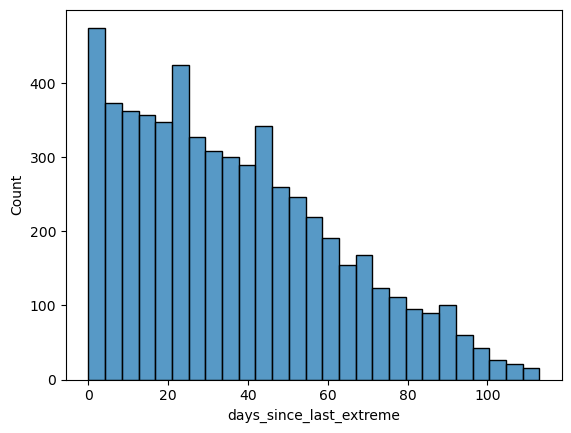

In [29]:
sns.histplot(strat.days_since_last_extreme)

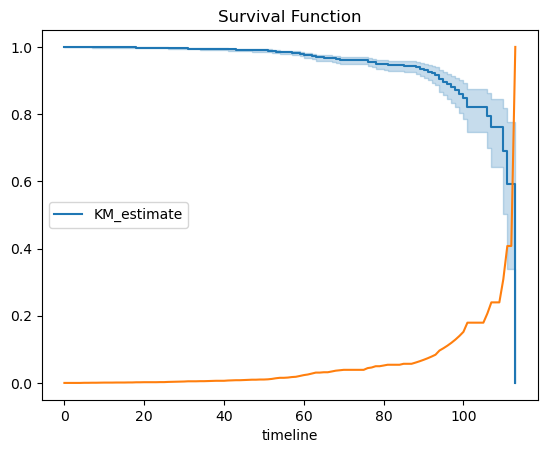

In [30]:
# Survival Model
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
T = strat['days_since_last_extreme']
E = strat["binary"]

kmf.fit(T, event_observed=E)
kmf.plot_survival_function()
plt.title('Survival Function')
plt.plot(kmf.cumulative_density_, label='Cumulative Density')

In [31]:
print(kmf.conditional_time_to_event_)

          KM_estimate - Conditional median duration remaining to event
timeline                                                              
0.0                                                   113.0           
1.0                                                   112.0           
2.0                                                   111.0           
3.0                                                   110.0           
4.0                                                   109.0           
...                                                     ...           
109.0                                                   4.0           
110.0                                                   3.0           
111.0                                                   2.0           
112.0                                                   1.0           
113.0                                                   0.0           

[114 rows x 1 columns]


In [32]:
cum_density = 1-kmf.cumulative_density_
cum_density

KM_estimate
timeline             
0.0          1.000000
1.0          1.000000
2.0          1.000000
3.0          1.000000
4.0          1.000000
...               ...
109.0        0.760267
110.0        0.691152
111.0        0.592416
112.0        0.592416
113.0        0.000000

[114 rows x 1 columns]

In [33]:
strat

Close   Returns  Volatility  GARCH_VAR  var_breach    EVA  \
Date                                                                         
2000-01-04   45.312500 -0.039735    0.030711   0.050490       False  False   
2000-01-05   46.625000  0.028966    0.031277   0.051419       False  False   
2000-01-06   50.375000  0.080429    0.031095   0.051120       False  False   
2000-01-07   51.375000  0.019851    0.035466   0.058307       False  False   
2000-01-10   51.125000 -0.004866    0.034740   0.057112       False  False   
...                ...       ...         ...        ...         ...    ...   
2023-03-01  110.209999  0.022926    0.017883   0.029400       False  False   
2023-03-02  109.900002 -0.002813    0.018162   0.029858       False  False   
2023-03-03  111.260002  0.012375    0.017688   0.029079       False  False   
2023-03-06  109.930000 -0.011954    0.017429   0.028654       False  False   
2023-03-07  107.089996 -0.025835    0.017210   0.028294       False   True   

            binary  days_since_last_extreme  
Date                                         
2000-01-04       0                        0  
2000-01-05       0                        1  
2000-01-06       0                        2  
2000-01-07       0                        3  
2000-01-10       0                        4  
...            ...                      ...  
2023-03-01       0                       24  
2023-03-02       0                       25  
2023-03-03       0                       26  
2023-03-06       0                       27  
2023-03-07       1                       28  

[5830 rows x 8 columns]

In [34]:
# days and loss severity
zero_index = strat[strat['days_since_last_extreme'] == 0].index
strat.reset_index(inplace=True)
# find the index of the matching dates
event_index = strat[strat['Date'].isin(zero_index)].index
event = strat.iloc[event_index - 1]
event

Date       Close   Returns  Volatility  GARCH_VAR  var_breach  \
5829 2023-03-07  107.089996 -0.025835    0.017210   0.028294       False   
36   2000-02-25   42.875000 -0.057692    0.027486   0.045187        True   
78   2000-04-26   44.468750 -0.051965    0.027518   0.045239        True   
171  2000-09-07   45.812500 -0.026560    0.013089   0.021518        True   
196  2000-10-12   45.437500 -0.025469    0.017301   0.028442       False   
...         ...         ...       ...         ...        ...         ...   
5567 2022-02-17  148.639999 -0.044914    0.014264   0.023451        True   
5620 2022-05-05  149.460007 -0.030928    0.017205   0.028286        True   
5698 2022-08-26  129.139999 -0.095405    0.014590   0.023986        True   
5704 2022-09-06  116.599998 -0.041513    0.024836   0.040831        True   
5800 2023-01-24  115.000000 -0.062143    0.018304   0.030091        True   

       EVA  binary  days_since_last_extreme  
5829  True       1                       28  
36    True       1                       36  
78    True       1                       41  
171   True       1                       92  
196   True       1                       24  
...    ...     ...                      ...  
5567  True       1                       54  
5620  True       1                       52  
5698  True       1                       77  
5704  True       1                        5  
5800  True       1                       95  

[95 rows x 9 columns]

/Users/yuhuiwang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



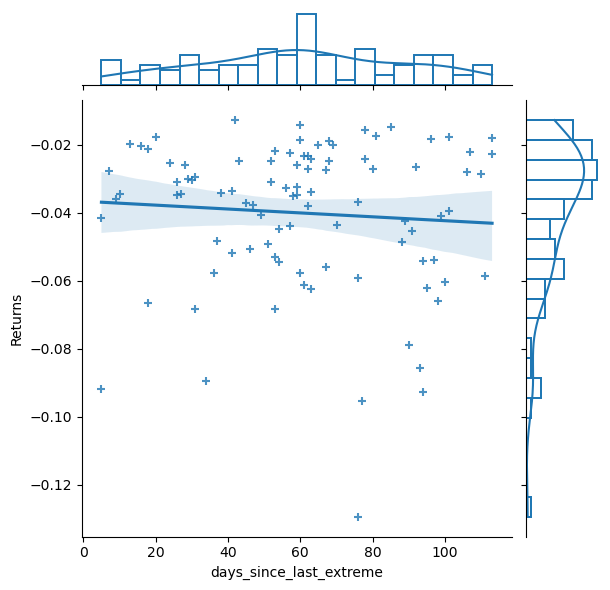

In [35]:
sns.jointplot(event.days_since_last_extreme, event.Returns, kind="reg",  marker="+", marginal_kws=dict(bins=20, fill=False))

In [36]:
strat.set_index(strat['Date'])

Date       Close   Returns  Volatility  GARCH_VAR  \
Date                                                                 
2000-01-04 2000-01-04   45.312500 -0.039735    0.030711   0.050490   
2000-01-05 2000-01-05   46.625000  0.028966    0.031277   0.051419   
2000-01-06 2000-01-06   50.375000  0.080429    0.031095   0.051120   
2000-01-07 2000-01-07   51.375000  0.019851    0.035466   0.058307   
2000-01-10 2000-01-10   51.125000 -0.004866    0.034740   0.057112   
...               ...         ...       ...         ...        ...   
2023-03-01 2023-03-01  110.209999  0.022926    0.017883   0.029400   
2023-03-02 2023-03-02  109.900002 -0.002813    0.018162   0.029858   
2023-03-03 2023-03-03  111.260002  0.012375    0.017688   0.029079   
2023-03-06 2023-03-06  109.930000 -0.011954    0.017429   0.028654   
2023-03-07 2023-03-07  107.089996 -0.025835    0.017210   0.028294   

            var_breach    EVA  binary  days_since_last_extreme  
Date                                                            
2000-01-04       False  False       0                        0  
2000-01-05       False  False       0                        1  
2000-01-06       False  False       0                        2  
2000-01-07       False  False       0                        3  
2000-01-10       False  False       0                        4  
...                ...    ...     ...                      ...  
2023-03-01       False  False       0                       24  
2023-03-02       False  False       0                       25  
2023-03-03       False  False       0                       26  
2023-03-06       False  False       0                       27  
2023-03-07       False   True       1                       28  

[5830 rows x 9 columns]

## Hedging Performance
Assuming our allocation follows the 1-cumulative density, and our return is directly proportional to the allocation.
In addition, when the density is lower than 80, we close all positions, i.e. zero return

In [37]:
# map the density to df
def check(x):
    if x < 0.987: a = 0 
    else: a = 1
    return a

strat['map'] = strat['days_since_last_extreme'].map(cum_density.to_dict()['KM_estimate'])
strat['map'] = strat['map'].apply(lambda x: check(x))
strat['mapped_return'] = strat['Returns'] * strat['map']
strat

Date       Close   Returns  Volatility  GARCH_VAR  var_breach  \
0    2000-01-04   45.312500 -0.039735    0.030711   0.050490       False   
1    2000-01-05   46.625000  0.028966    0.031277   0.051419       False   
2    2000-01-06   50.375000  0.080429    0.031095   0.051120       False   
3    2000-01-07   51.375000  0.019851    0.035466   0.058307       False   
4    2000-01-10   51.125000 -0.004866    0.034740   0.057112       False   
...         ...         ...       ...         ...        ...         ...   
5825 2023-03-01  110.209999  0.022926    0.017883   0.029400       False   
5826 2023-03-02  109.900002 -0.002813    0.018162   0.029858       False   
5827 2023-03-03  111.260002  0.012375    0.017688   0.029079       False   
5828 2023-03-06  109.930000 -0.011954    0.017429   0.028654       False   
5829 2023-03-07  107.089996 -0.025835    0.017210   0.028294       False   

        EVA  binary  days_since_last_extreme  map  mapped_return  
0     False       0                        0    1      -0.039735  
1     False       0                        1    1       0.028966  
2     False       0                        2    1       0.080429  
3     False       0                        3    1       0.019851  
4     False       0                        4    1      -0.004866  
...     ...     ...                      ...  ...            ...  
5825  False       0                       24    1       0.022926  
5826  False       0                       25    1      -0.002813  
5827  False       0                       26    1       0.012375  
5828  False       0                       27    1      -0.011954  
5829   True       1                       28    1      -0.025835  

[5830 rows x 11 columns]

<AxesSubplot:>

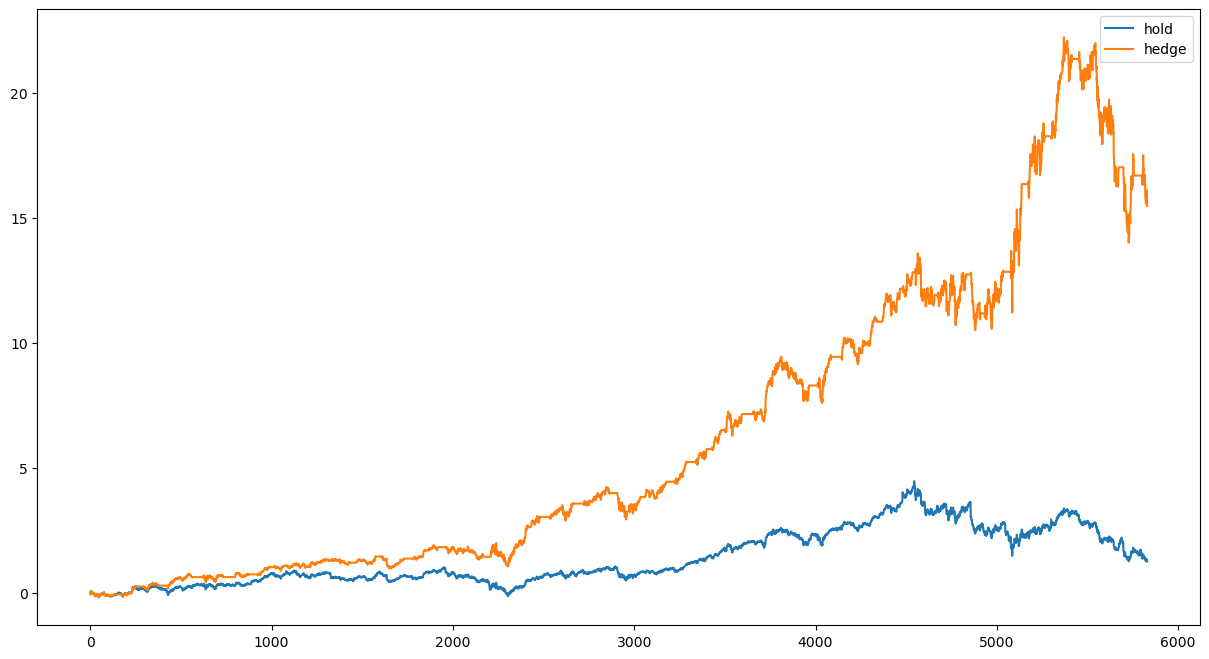

In [38]:
# plot cumulative return
strat['hold'] = strat.Returns.expanding().apply(lambda x: np.prod(x+1)) - 1
strat['hedge'] = strat.mapped_return.expanding().apply(lambda x: np.prod(x+1)) - 1

strat[['hold', 'hedge']].plot(figsize = (15,8))

Maximum strategy sharpe ratio:  0.04409632961559238
Maximum strategy threshold:  0.9870000000000002


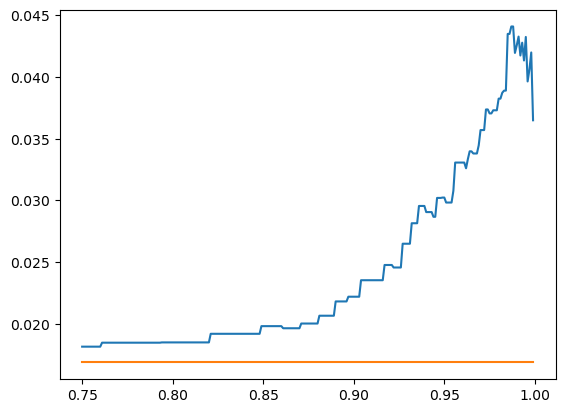

In [39]:
# calculate the sharpe ratio for all thresholds
def sharpe_ratio(threshold):
    def check(x):
        if x < threshold: a = 0 
        else: a = 1
        return a

    strat['map'] = strat['days_since_last_extreme'].map(cum_density.to_dict()['KM_estimate'])
    strat['map'] = strat['map'].apply(lambda x: check(x))
    strat['mapped_return'] = strat['Returns'] * strat['map']

    sharpe = strat['mapped_return'].mean() / strat['mapped_return'].std()
    return sharpe

s = []

for i in np.arange(0.75, 1, 0.001):
    s.append(sharpe_ratio(i))

plt.plot(np.arange(0.75, 1, 0.001), s)
plt.plot(np.arange(0.75, 1, 0.001), np.full(len(s), strat['Returns'].mean() / strat['Returns'].std()))

print('Maximum strategy sharpe ratio: ', max(s))
print('Maximum strategy threshold: ', np.arange(0.75, 1, 0.001)[s.index(max(s))])

Note this does not solve the problem of volatility clustering as well as systematic risk events